In [6]:
#import library
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [10]:
#load the dataset
#Black pod rot dataset
folder_path_black_pod_rot = '/content/drive/MyDrive/Capstone/cocoa_diseases/black_pod_rot'
item_black_pod_rot = os.listdir(folder_path_black_pod_rot)
count_black_pod_rot = len(item_black_pod_rot)

#Healthy
folder_path_healthy = '/content/drive/MyDrive/Capstone/cocoa_diseases/healthy'
item_healthy = os.listdir(folder_path_healthy)
count_healthy = len(item_healthy)

#pod_borer
folder_path_pod_borer = '/content/drive/MyDrive/Capstone/cocoa_diseases/pod_borer'
item_pod_borer = os.listdir(folder_path_pod_borer)
count_pod_borer = len(item_pod_borer)

print(f"Amount black pod rot items in folder: {count_black_pod_rot}")
print(f"Amount healthy items in folder: {count_healthy}")
print(f"Amount pod borer items in folder: {count_pod_borer}")

Amount black pod rot items in folder: 500
Amount healthy items in folder: 500
Amount pod borer items in folder: 208


In [13]:
#define paths
source_dir = '/content/drive/MyDrive/Capstone'
train_dir = os.path.join(source_dir, 'train')
test_dir = os.path.join(source_dir, 'test')
validation_dir = os.path.join(source_dir, 'validation')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

In [16]:
#splitting data
#define the class names
data_dir = '/content/drive/MyDrive/Capstone/cocoa_diseases'
class_names = ['black_pod_rot', 'healthy', 'pod_borer']

#define the desired split ratios (adjust as needed)
train_ratio = 0.8  # 70% for training
test_ratio = 0.1   # 20% for testing
valid_ratio = 0.1  # 10% for validation

#iterate over each class directory
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)
    total_images = len(images)

    # Split the images into train, test, and validation sets
    train_split = int(train_ratio * total_images)
    test_split = int((train_ratio + test_ratio) * total_images)

    train_images = images[:train_split]
    test_images = images[train_split:test_split]
    valid_images = images[test_split:]

    # Move images to respective directories
    for image in train_images:
        src_path = os.path.join(class_dir, image)
        dst_path = os.path.join(train_dir, class_name, image)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

    for image in test_images:
        src_path = os.path.join(class_dir, image)
        dst_path = os.path.join(test_dir, class_name, image)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

    for image in valid_images:
        src_path = os.path.join(class_dir, image)
        dst_path = os.path.join(validation_dir, class_name, image)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

#function to count the number of files in a directory
def count_files(directory):
    count = sum([len(files) for r, d, files in os.walk(directory)])
    return count

#count the number of files in each directory
data_count = count_files(data_dir)
train_count = count_files(train_dir)
test_count = count_files(test_dir)
valid_count = count_files(validation_dir)

#print the results
print("Total data count:", data_count)
print("Train data count:", train_count)
print("Test data count:", test_count)
print("Validation data count:", valid_count)

Total data count: 1208
Train data count: 1202
Test data count: 327
Validation data count: 332


In [19]:
#standarizing images
def train_val_generators(train_dir, test_dir, validation_dir):

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(150, 150))
  
  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  test_datagen = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(150, 150))
  
  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(150, 150))
  return train_generator, test_generator, validation_generator

train_generator, test_generator, validation_generator = train_val_generators(train_dir, test_dir, validation_dir)

Found 1202 images belonging to 3 classes.
Found 327 images belonging to 3 classes.
Found 332 images belonging to 3 classes.


In [25]:
#creating model
def create_model():
  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2), 
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(), 
      tf.keras.layers.Dense(512, activation='relu'), 
      tf.keras.layers.Dense(3, activation='softmax'),
  ])

  from tensorflow.keras.optimizers import RMSprop  
  model.compile(optimizer=RMSprop(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 
  return model

In [26]:
#training the model
# Get the untrained model
model = create_model()

# Train the model
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
38/38 [==============================] - 59s 2s/step - loss: 1.1878 - accuracy: 0.4393 - val_loss: 0.9411 - val_accuracy: 0.4488
Epoch 2/15
38/38 [==============================] - 54s 1s/step - loss: 0.9790 - accuracy: 0.4925 - val_loss: 0.9023 - val_accuracy: 0.5813
Epoch 3/15
38/38 [==============================] - 55s 1s/step - loss: 0.9201 - accuracy: 0.5632 - val_loss: 0.8719 - val_accuracy: 0.6024
Epoch 4/15
38/38 [==============================] - 56s 1s/step - loss: 0.9046 - accuracy: 0.5724 - val_loss: 0.7888 - val_accuracy: 0.6054
Epoch 5/15
38/38 [==============================] - 57s 2s/step - loss: 0.8334 - accuracy: 0.6215 - val_loss: 1.5396 - val_accuracy: 0.5934
Epoch 6/15
38/38 [==============================] - 54s 1s/step - loss: 0.8278 - accuracy: 0.6323 - val_loss: 0.6716 - val_accuracy: 0.6958
Epoch 7/15
38/38 [==============================] - 54s 1s/step - loss: 0.7927 - accuracy: 0.6439 - val_loss: 0.7319 - val_accuracy: 0.6898
Epoch 8/15
38/38 [==

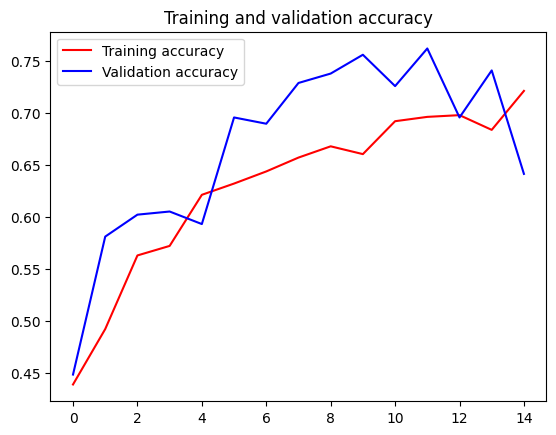

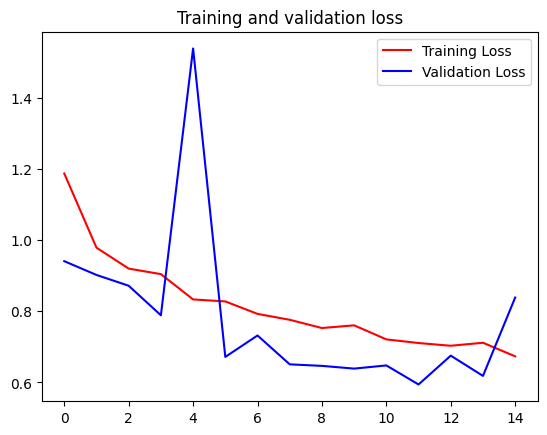

In [27]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [28]:
#Model evaluating
val_loss, val_acc = model.evaluate(validation_generator)
print('Validation Loss: ',val_loss),
print('Validation Accuracy: ',val_acc)

11/11 [==============================] - 6s 562ms/step - loss: 0.8387 - accuracy: 0.6416
Validation Loss:  0.8387426137924194
Validation Accuracy:  0.641566276550293
